## To use:
Execute all cells below to load libraries and function definitions.  
Under the 'Plot' heading, execute the blocks to make predictions, change the parameters of XGBoost, make plots, and view correlations.

In [5]:
# import required libs
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
import numpy as np
from copy import copy
from sklearn.metrics import mean_squared_error, ndcg_score, r2_score
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, kendalltau

## Load Data

In [2]:
hdata_ord = pd.read_pickle('./pickle/hyp_data_ranking.p') # read in the data

gdata_ord = pd.read_pickle('./pickle/graph_data_ranking.p') # read in the data

## Hypergraph Ranker

In [229]:
def xg_hyp(df=hdata_ord,train_size=0.8,learning_rate=0.2,n_estimators=200):
    features = ['degree','centrality1','centrality2','centrality3']
    X = df[features]
    y = df['rank']
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
    
    model_h = xgb.XGBRanker(  
        tree_method='gpu_hist',
        booster='gbtree',
        objective='rank:pairwise',
        #random_state=42, 
        learning_rate=learning_rate,
        colsample_bytree=0.9, 
        max_depth=15, 
        n_estimators=n_estimators, 
        subsample=0.75 
        )

    model_h.fit(X_train, y_train,group=[int(train_size*497)])

    pred = model_h.predict(df[features])
    hdata_pred = copy(df[['rank']])
    hdata_pred['pred'] = pred
    hdata_pred = hdata_pred.sort_values('pred', ascending=False)
    hdata_pred['pred_rank'] = range(497,0,-1)
    hdata_pred = hdata_pred.sort_values('rank')
    return hdata_pred

## Pairwise Graph

In [230]:
def xg_pair(df=gdata_ord,train_size=0.8,learning_rate=0.2,n_estimators=200):
    gfeatures = ['degree','centrality']
    X = df[gfeatures]
    y = df['rank']
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
    
    model_g = xgb.XGBRanker(  
        tree_method='gpu_hist',
        booster='gbtree', 
        objective='rank:pairwise',
        #random_state=42, 
        learning_rate=learning_rate,
        colsample_bytree=0.9, 
        max_depth=15, 
        n_estimators=n_estimators, 
        subsample=0.75 
        )

    model_g.fit(X_train, y_train,group=[int(train_size*497)])
    
    gpred = model_g.predict(df[gfeatures])
    gdata_pred = copy(df[['rank']])
    gdata_pred['pred'] = gpred
    gdata_pred = gdata_pred.sort_values('pred',ascending=False)
    gdata_pred['pred_rank'] = range(497,0,-1)
    gdata_pred = gdata_pred.sort_values('rank')
    return gdata_pred

### Calculate correlations

Given a dataframe containing columns 'rank' and 'pred_rank' (empirical rank and predicted rank)

In [231]:
def corr(df) -> dict:

    rank = df['rank']

    pred_rank = df['pred_rank']

    correlations = {}

    correlations['mse'] = mean_squared_error([rank],[pred_rank])

    correlations['ndcg'] = ndcg_score([rank],[pred_rank])

    correlations['ktau'] = kendalltau(pred_rank,list(range(1,498)))[0]

    correlations['pval-ktau'] = kendalltau(pred_rank,list(range(1,498)))[1]

    correlations['pearsonr'] = pearsonr(rank,pred_rank)[0]

    correlations['pval-pearsonr'] = pearsonr(rank,pred_rank)[1]
    
    correlations['r2'] = r2_score(rank, pred_rank)

    return correlations

In [232]:
def pretty_corr(c): # pretty print output from corr()
    print(f"""
    Mean squared error (RMS): \t{c['mse']:.0f} ({c['mse']**.5:.5})
    Normalised discounted
      cumulative gain: \t\t{c['ndcg']:.5}
    Kendall Tau: \t\t{c['ktau']:.5}
    \tKtau p-value: \t\t{c['pval-ktau']:.5}
    Pearson's r: \t\t{c['pearsonr']:.5}
    \tPearson's r p-value: \t{c['pval-pearsonr']:.5}
    Coef. of determination \t{c['r2']:.5}
    """)

### Calculate metric averages

From a list of dictionaries, return a single dictionary with the averages.  
For use with a list, with each item being an output from corr()

In [233]:
def met_avgs(met_list) -> dict: # given a list of dictionaries of metrics, return a dict of their averages
    keys = met_list[0].keys()
    list_len = len(met_list)
    ret_dict = {}
    for k in keys:
        ret_dict[k] = 0
    for d in met_list:
        for m in d:
            ret_dict[m] += d[m]
    for m in ret_dict:
        ret_dict[m]/=list_len
    
    return ret_dict

===================================================

# Plots

In [234]:
ts = 0.8 # training size
lr = 0.2 # learning rate
n_t = 150 # n_estimators (number of trees)

In [235]:
h_corr = []
g_corr = []
for i in range(1): # change to average over many iterations
    h_pred = xg_hyp(df=hdata_ord,train_size=ts,learning_rate=lr,n_estimators=n_t)
    g_pred = xg_pair(df=gdata_ord,train_size=ts,learning_rate=lr,n_estimators=n_t)
    
    h_corr.append(corr(h_pred))
    g_corr.append(corr(g_pred))
    
avg_hyp_corr = met_avgs(h_corr) # take average of all the correlation values calculated
#avg_graph_corr = met_avgs(g_corr)

In [236]:
# Pretty print the correlations
print("-----------------------------------------")
print("Hypergraph ranking correlations:")
pretty_corr(avg_hyp_corr)
print("-----------------------------------------")
print("Pair graph ranking correlations:")
pretty_corr(avg_graph_corr)

-----------------------------------------
Hypergraph ranking correlations:

    Mean squared error (RMS): 	6527 (80.792)
    Normalised discounted
      cumulative gain: 		0.98253
    Kendall Tau: 		0.70416
    	Ktau p-value: 		9.3677e-122
    Pearson's r: 		0.84145
    	Pearson's r p-value: 	1.9964e-134
    Coef. of determination 	0.68289
    
-----------------------------------------
Pair graph ranking correlations:

    Mean squared error (RMS): 	16712 (129.28)
    Normalised discounted
      cumulative gain: 		0.95928
    Kendall Tau: 		0.42845
    	Ktau p-value: 		4.9892e-44
    Pearson's r: 		0.59405
    	Pearson's r p-value: 	1.4168e-45
    Coef. of determination 	0.18811
    


### Make plots of the ranking predictions.  
*Note: this uses the final calculated values of h_pred and g_pred from the above 'for' loop*

In [237]:
#get coefficients for line of best fit
hm, hb = np.polyfit(h_pred['rank'],h_pred['pred_rank'],1)
gm, gb = np.polyfit(g_pred['rank'],g_pred['pred_rank'],1)

[Text(0.5, 0, 'Empirical Rank'), Text(0.5, 1.0, 'Pairwise Graph'), None]

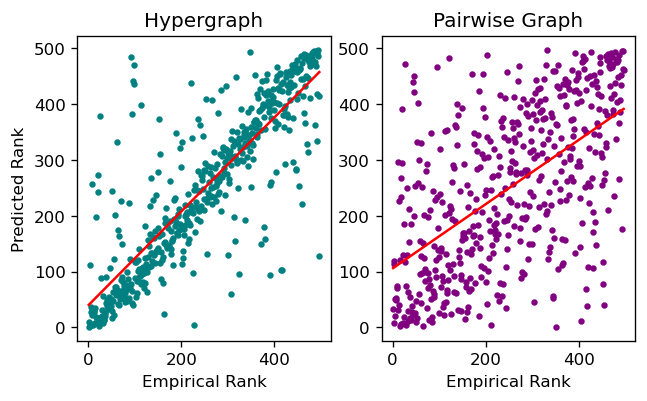

In [244]:
_, (ax1, ax2) = plt.subplots(1, 2, dpi=120)

ax1.scatter(h_pred['rank'],h_pred['pred_rank'], c='teal', s=8)
ax1.plot(h_pred['rank'],hm*h_pred['rank']+hb,c='red') # uncomment for line of best fit 
ax1.set(xlabel='Empirical Rank',ylabel='Predicted Rank',title='Hypergraph',aspect=1.2)

ax2.scatter(g_pred['rank'],g_pred['pred_rank'], c='purple', s=8)
ax2.plot(g_pred['rank'],gm*g_pred['rank']+gb,c='red') # uncomment for line of best fit 
ax2.set(xlabel='Empirical Rank',title='Pairwise Graph',aspect=1.2)

In [239]:
def pred_in_eps(pred,true,eps): # returns list of True/False values indicating for each predicted value if it falls within eps of the true value
    res = []
    #for n in range(len(pred)):
    #    res.append(True if np.abs(pred[n]-true[n])<eps else False)
    
    res = [True if np.abs(pred[n]-true[n])<eps else False for n in range(len(pred))]
    
    return res

In [240]:
f = lambda x: 100*sum(pred_in_eps(h_pred['pred_rank'],h_pred['rank'],x))/len(h_pred)
g = lambda x: 100*sum(pred_in_eps(g_pred['pred_rank'],g_pred['rank'],x))/len(g_pred)

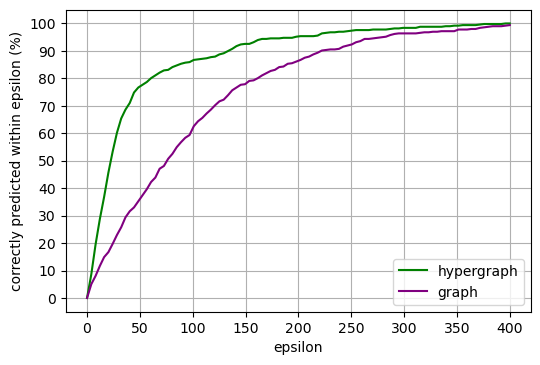

In [245]:
x = np.linspace(0,400,100)
y1 = [f(a) for a in x]
y2 = [g(a) for a in x]
plt.figure(dpi=100)
plt.xlabel('epsilon')
plt.ylabel('correctly predicted within epsilon (%)')
plt.yticks(ticks=range(0,101,10))
plt.grid(visible=True,which='both')
plt.plot(x, y1, c='green', label='hypergraph')
plt.plot(x, y2, c='purple', label='graph')
plt.legend(loc='lower right')